In [1]:
%cd ../src
import pickle
import pandas as pd
from utils import IMAGE_TYPES, RDF_DATE_TYPES, RDF_NUMBER_TYPES, POTENTIAL_TEXT_TYPES, RDF_DATE_TYPES, get_relevant_relations
import matplotlib.pyplot as plt
from preprocess import VGG_image_classification


e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dataset(dataset):
    with open(f"../data/raw/{dataset}_final_torch_None.pickle", "rb") as f:
        data = pickle.load(f)
    
    print("# nodes")
    print(len(data.i2e))
    print("datatypes")
    print(data.datatypes())
    return data

In [3]:
data = load_dataset('amplus')

# nodes
1153221
datatypes
['iri', 'blank_node', 'none', 'http://kgbench.info/dt#base64Image', 'http://www.w3.org/2001/XMLSchema#date', 'http://www.w3.org/2001/XMLSchema#decimal', 'http://www.w3.org/2001/XMLSchema#positiveInteger']


In [4]:
data = VGG_image_classification(data)

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0        921
1        425
2        921
3        666
4        117
        ... 
58850    633
58851    551
58852    883
58853    619
58854    714
Name: class, Length: 58855, dtype: int64


In [37]:
# from .util import here, tic, toc, getfile
# from .urls import URLS
import numpy as np

from os.path import join
from pathlib import Path

import pandas as pd
import gzip, base64, io, sys, warnings, wget, os, random

import torch
from utils import get_relevant_relations, IMAGE_TYPES
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
URI_PREFIX ="test"

In [6]:
def is_image(b64):
    try:
        imgdata = base64.urlsafe_b64decode(b64)
    except:
        # print(f'Could not decode b64 string {b64}')
        return False
    return True

In [7]:
def get_image(b64):
    try:
        imgdata = base64.urlsafe_b64decode(b64)
    except:
        print(f'Could not decode b64 string {b64}')
        return Image.new('RGB', (1, 1))


    try:
        return Image.open(io.BytesIO(base64.urlsafe_b64decode(b64)))
    except:
        return Image.new('RGB', (1, 1))

        

In [8]:
relevant_relations = get_relevant_relations(data, IMAGE_TYPES)
df = pd.DataFrame(data.triples[torch.isin(data.triples[:,1],torch.tensor(relevant_relations))], columns = ["s","p","o"])
vgg = models.vgg16(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)
vgg.eval()

preprocess = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def eval_image(image, preprocess, model, device= "cpu"):
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch.to(device)
    return vgg(input_batch).squeeze(0).softmax(0).argmax().item()


In [20]:

df["b64"] = df['o'].apply(lambda x: data.i2e[x][0])
df["is_image"] = df["b64"].apply(lambda x: is_image(x))
df = df[df['is_image']==True]
df["image"] = df['b64'].apply(lambda x: get_image(x))
df['class']= df["image"].apply(lambda x: eval_image(x, preprocess=preprocess, model= vgg, device= device) )


C:\Users\Noctris\AppData\Local\Temp\ipykernel_16728\1341602400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["b64"] = df['o'].apply(lambda x: data.i2e[x][0])
C:\Users\Noctris\AppData\Local\Temp\ipykernel_16728\1341602400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_image"] = df["b64"].apply(lambda x: is_image(x))


In [39]:
for pred in df['p'].unique(): # use this over relation since loading image can subset df
    sub_df = df[df['p']==pred]
    p = f'{URI_PREFIX}predicat#img-class-{pred}'
    new_id = len(data.i2r)
    data.r2i[p] = new_id
    data.i2r.append(p)
    data.num_relations += 1
    for c in sub_df["class"].unique():
        o = (f'{URI_PREFIX}entity#img-class-{c}-{pred}',
        f'{URI_PREFIX}datatype#img-class')
        new_id = len(data.i2e)
        data.e2i[o] = new_id
        data.i2e.append(o)
        data.num_entities += 1

        
    sub_df['new_o'] = sub_df["class"].apply(lambda c: data.e2i[(f'{URI_PREFIX}entity#img-class-{c}-{pred}',
        f'{URI_PREFIX}datatype#img-class')])
    sub_df['new_p'] = sub_df["class"].apply(lambda f: data.r2i[f'{URI_PREFIX}predicat#img-class-{pred}'])
    #print(df)
    ten = torch.tensor(sub_df[['s','new_p','new_o']].values.astype(np.int32), dtype= torch.int32)
    data.triples = torch.cat((data.triples, ten), 0)

C:\Users\Noctris\AppData\Local\Temp\ipykernel_16728\1004141515.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['new_o'] = sub_df["class"].apply(lambda c: data.e2i[(f'{URI_PREFIX}entity#img-class-{c}-{pred}',
C:\Users\Noctris\AppData\Local\Temp\ipykernel_16728\1004141515.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['new_p'] = sub_df["class"].apply(lambda f: data.r2i[f'{URI_PREFIX}predicat#img-class-{pred}'])
C:\Users\Noctris\AppData\Local\Temp\ipykernel_16728\1004141515.py:17: Sett

In [41]:
data.triples

tensor([[185557,    131, 127327],
        [182860,     25, 119738],
        [207157,     45, 293297],
        ...,
        [188968,    160, 350676],
        [204311,    160, 350676],
        [230999,    160, 350676]], dtype=torch.int32)

In [42]:
data.i2e[350676]

('testentity#img-class-644-9', 'testdatatype#img-class')

In [23]:
len(df)

68432

In [26]:
len(df['class'])

68432

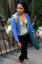

In [13]:
df["image"].iloc[0]

In [19]:
eval_image(df["image"].iloc[3], preprocess=preprocess, model= vgg, device= device)

906

In [72]:
df

,s,p,o,b64,image,is_image
0,207157,45,293297,iVBORw0KGgoAAAANSUhEUgAAACoAAABACAIAAADjznIwAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
1,257290,29,86418,http://commons.wikimedia.org/wiki/Special:File...,<PIL.Image.Image image mode=RGB size=1x1 at 0x...,True
2,229304,45,304193,iVBORw0KGgoAAAANSUhEUgAAACsAAABACAIAAAAMDBkOAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
3,120986,45,326434,iVBORw0KGgoAAAANSUhEUgAAADkAAABACAIAAAAvV0jbAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
4,170295,45,299580,iVBORw0KGgoAAAANSUhEUgAAACsAAABACAIAAAAMDBkOAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
...,...,...,...,...,...,...
70180,213627,45,337042,iVBORw0KGgoAAAANSUhEUgAAAEAAAAArCAIAAABHOBkQAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
70181,107134,45,286640,iVBORw0KGgoAAAANSUhEUgAAAC8AAABACAIAAAAF57l0AA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
70182,166861,45,283867,iVBORw0KGgoAAAANSUhEUgAAAC4AAABACAIAAADqJdJKAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True
70183,246237,45,330935,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAiCAIAAABgN0jYAA...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,True


In [ ]:
for triple in df:
    b64 = data.i2e[triple[2]][0]
    

In [45]:
data.i2e[df[0,2]][0]

'iVBORw0KGgoAAAANSUhEUgAAACoAAABACAIAAADjznIwAAAYYElEQVR4nC2YyY/d6XWez/mm33TnW7fmiSySTTab6lnR2BqsIdFkwXESBDBiBEkWtrMSDCTeGcjKi3gbIAgSA1kkhgC1hUCQZbtlu6WW1C25RTabzblIVhWr6t668/2N33SyoM8/cBYP8OB9X/zM6ztDHisejcfzms8rD5sr9VRXLz5/GQWbZFnT2pPjPGQ0medHg9H6xauDfn8+m6qlepx0q7Ks8rmhCoESMo2EmQwPR7kUWOU67tU65zsBj1wxGwznjGFci8l6VznGhPee8VAlZDNrQsSs8oyoMC4RIk2zdhwhQ86YFIyQEzLFoH90NOyfeQwltJSPV5srIW8Jm4RWMIsOAbkTAJyj4DJcCtEyJaW1jnPkglunrbYICAAAwEYgm6EAb4I4RM+N0aXHULDxdF6LJHk6Gy1kEEgZo5Clw+F4RiLiYQ2B6XzePz0tysoZms/MIifnASXFASdDsqlUTYQkOQCRFVwwzsADEhNSIhKBZ9yYBWGHQw6+WYutgdK6SrvJNDXGKYHj+VxJ5V2ljU2SsLW+LZNGV/oXNzoB2OPjo3w+sbpARmlapnOTWycUMsaS1QTIS4HOFR4AGQmB4FEIiYiegAhEm+GZsYFzZJxI4malZ1nlwsR7O54u2vXaPpDLp4t5gQShFP3Tg0s7W3/6+78TC/Xu+9f/4uf01q3HDBxyAYSzma6h4B5lLFRTUWVlFBZ2Tg44Ss6YI4ucEZEHAgDGGDXQL6yLkaZaN5IYnZ8VtsxNlpcBY1wpZ7NaFNUDWRSlce43P/va3lIcmvkXru39p2998rmlqNLWW+29JUfkEL0LOhE55w0poTg+ewXOEgeOgM5ZZ5z3xHS9XhMiDqW2lqxZeFcPwtLYIi8LbXVpitJWHhrNtnHOOIcIS/Vw2D+enB2NhofMZl+9usLAefLee08A1leOZC30xnqPCj0n4yw

In [48]:
from PIL import Image

# res:Image
# Take in base64 string and return cv image
num_noparse = 0
b64 = data.i2e[df[0,2]][0]

try:
    imgdata = base64.urlsafe_b64decode(b64)
except:
    print(f'Could not decode b64 string {b64}')
    sys.exit()

try:
    res = Image.open(io.BytesIO(imgdata))
except:
    res = Image.new('RGB', (1, 1))
    # num_noparse += 1
    # res.append(Image.new('RGB', (1, 1)))
        # -- If the image can't be parsed, we insert a 1x1 black image

# if num_noparse > 0:
#     warnings.warn(f'There were {num_noparse} images that couldn\'t be parsed. These have been replaced by black images.')

# # print(num_noparse, 'unparseable', len([r for r in res if r is not None]), 'parseable')

# return res

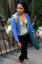

In [49]:
res

In [7]:
img = data.get_images()[0]

In [11]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [31]:
# Preprocessing steps
import torchvision.transforms as transforms
preprocess = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [32]:
input_tensor = preprocess(img)

In [33]:
input_batch = input_tensor.unsqueeze(0)

In [35]:
p = vgg(input_batch).squeeze(0).softmax(0)

In [37]:
p.argmax().item()

399

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

In [24]:
vgg(input_tensor )

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x49 and 25088x4096)

In [8]:
import torch
import torchvision.models as models

# Load pre-trained VGG model
vgg = models.vgg16(pretrained=True)

# Set the model to evaluation mode
vgg.eval()

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Noctris/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.6MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
vgg(img)

TypeError: conv2d() received an invalid combination of arguments - got (PngImageFile, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!PngImageFile!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!PngImageFile!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
